In [2]:
import sys
sys.path.insert(0, '../')

from src.time_tagger import TimeTaggerController, TT_Simulator, two_particle_states
from src.kinetic_mount_controller import KineticMountControl
from src.osc import OSCCommunicator, OSCTarget
import time
import threading
import random

# Setup Mount Controller

In [4]:
# only run if not already created
if 'KMC' not in globals():  
    KMC = KineticMountControl(number_of_devices=2, address_search_depth=0)
    #KMC.swap_alice_bob()


ASSIGNING CONTROLLERS
---------------------------------------------------------------
Ports Found: []


Exception: 

No ports found does not match specified number of devices


In [5]:
# Init the Time Tagger and the Kinetic Mount Controller
TTC = TimeTaggerController()

# NOTE Look at the trace, sucessively block each port and assign the channels numbers in the next cell
# NOTE afterwards stop and close the graphic
#TTC.displayCountTraces()

RuntimeError: No Time Tagger attached or already in use. Got the USB error 'Failed' in 'OpenBySerial' in line 176.

In [6]:
# connect KMC and TTC
TTC.setKineticMountController(KMC)
# set alice channels
TTC.set_alice_reflection_channel(3)
TTC.set_alice_transmission_channel(4)
# set bob channels
TTC.set_bob_reflection_channel(2)
TTC.set_bob_transmission_channel(1)


# set bob home offset
KMC.bob.set_home_offset(-43 % 360)
KMC.bob.home()
# set alice home offset
KMC.alice.set_home_offset(9)
KMC.alice.home()



NameError: name 'TTC' is not defined

In [7]:

#efficiencies
aT = 1
aR = 1
bT = 1
bR = 1
Simulator= TT_Simulator(two_particle_states['phi_plus'], initial_state_noise=0, detector_efficiencies=[aT*bT, aT*bR, aR*bT, aR*bR], debug=False)
CHSH_angles = Simulator.CHSH_angles_for_filters
Simulator.outcome_probabilities(0, 25)

cos(2*theta_a - 2*theta_b)
cos(2*theta_a - 2*theta_b)


array([[0.49124151],
       [0.00875849],
       [0.00875849],
       [0.49124151]])

In [8]:
TTC.measureS(CHSH_angles=CHSH_angles, integration_time_per_basis_setting_SI=2, TTSimulator=Simulator, coincidence_window_SI=1.0e-9, debug=True)

NameError: name 'TTC' is not defined

In [9]:
import numpy as np
import sympy as sp
from sympy.physics.quantum import TensorProduct, Dagger
from sympy.physics.quantum.trace import Tr
from scipy.optimize import minimize
def half_wave_plate_sympy(theta):
    """
    returns operator for action of HWP 1 particle state in H,V basis
    note that the angles here are in terms of the angle of the EM field oscillation orientation, not the filter orientation
    the angle for the filter is to be half the angle specified here
    """
    c = sp.cos(theta)
    s = sp.sin(theta)
    return sp.Matrix([[c, s], [s, -c]])

In [10]:
# Define sympy variables 
theta_a, theta_b = sp.symbols('theta_a, theta_b', real=True)

# Define Operator corresponding to two HWPs
HWP_operator = sp.simplify(TensorProduct(half_wave_plate_sympy(theta_a), half_wave_plate_sympy(theta_b)))


# Apply HWP operator on initial state density
rho = sp.simplify(HWP_operator * Simulator.initial_state_density * Dagger(HWP_operator))


aT, aR, bT, bR = sp.symbols('aT, aR, bT, bR', real=True)
detector_efficiencies = [aT*bT, aT*bR, aR*bT, aR*bR]

probability_vector = sp.Matrix([
            detector_efficiencies[0] * Tr(rho * Simulator.HH_operator),
            detector_efficiencies[1] * Tr(rho * Simulator.HV_operator),
            detector_efficiencies[2] * Tr(rho * Simulator.VH_operator),
            detector_efficiencies[3] * Tr(rho * Simulator.VV_operator)
        ])

probability_vector /= sum(probability_vector)
probability_vector.simplify()

probability_vector

Matrix([
[aT*bT*cos(theta_a - theta_b)**2/(aR*bR*cos(theta_a - theta_b)**2 + aR*bT*sin(theta_a - theta_b)**2 + aT*bR*sin(theta_a - theta_b)**2 + aT*bT*cos(theta_a - theta_b)**2)],
[aT*bR*sin(theta_a - theta_b)**2/(aR*bR*cos(theta_a - theta_b)**2 + aR*bT*sin(theta_a - theta_b)**2 + aT*bR*sin(theta_a - theta_b)**2 + aT*bT*cos(theta_a - theta_b)**2)],
[aR*bT*sin(theta_a - theta_b)**2/(aR*bR*cos(theta_a - theta_b)**2 + aR*bT*sin(theta_a - theta_b)**2 + aT*bR*sin(theta_a - theta_b)**2 + aT*bT*cos(theta_a - theta_b)**2)],
[aR*bR*cos(theta_a - theta_b)**2/(aR*bR*cos(theta_a - theta_b)**2 + aR*bT*sin(theta_a - theta_b)**2 + aT*bR*sin(theta_a - theta_b)**2 + aT*bT*cos(theta_a - theta_b)**2)]])

In [11]:
# correlation function
# TODO: Note this treatment of the detector efficiency is probably quite wrong, since the correlation function already is normalised to the amount of detected photons (at least the way it is calculated in the experiment), thusnthis is most likely wrong and the reason for the
# end result not quite looking like what we see in real life
C = detector_efficiencies[0] * Tr(rho * Simulator.HH_operator) - detector_efficiencies[1] * Tr(rho * Simulator.HV_operator)- detector_efficiencies[2] * Tr(rho * Simulator.VH_operator) + detector_efficiencies[3] * Tr(rho * Simulator.VV_operator)
C = C.simplify()
C_Lambdified = sp.lambdify([theta_a, theta_b, aT, aR, bT, bR], C)
C

aR*bR*cos(theta_a - theta_b)**2/2 - aR*bT*sin(theta_a - theta_b)**2/2 - aT*bR*sin(theta_a - theta_b)**2/2 + aT*bT*cos(theta_a - theta_b)**2/2

In [12]:
# S value
efficiencies = [0,1,1,1]

def S(x):
    a0 = x[0] * np.pi 
    a1 = x[1] * np.pi 
    b0 = x[2] * np.pi 
    b1 = x[3] * np.pi 
    return np.abs(C_Lambdified(a0, b0, *efficiencies) + C_Lambdified(a1, b0, *efficiencies) + C_Lambdified(a0, b1, *efficiencies) - C_Lambdified(a1, b1, *efficiencies))

S([0, 0.25, -0.3750, 0.375])

np.float64(1.414213562373095)

It seems like with the treatment of the detector inefficiencies as shown above it is indeed impossible to improve the S value with worse detector efficiencies (also plotted in desmos3d). But this is most likely due to a wrong implementation of detector inefficiencies.

# Kraus States and Modelling Loss as a vacuume state


In [65]:
def half_wave_plate_vac_sympy(theta):
    """
    returns operator for action of HWP 1 particle state in H,V,Vac basis
    note that the angles here are in terms of the angle of the EM field oscillation orientation, not the filter orientation
    the angle for the filter is to be half the angle specified here
    """
    c = sp.cos(theta)
    s = sp.sin(theta)
    return sp.Matrix([[c, s, 0], [s, -c, 0], [0, 0, 1]])

# Define |H>, |V> in 
H = sp.Matrix([1, 0, 0])
V = sp.Matrix([0, 1, 0])
Vac = sp.Matrix([0, 0, 1])
I3 = sp.eye(3)

# Define Bell state vectors and state density
phi_plus = (TensorProduct(H, H) + TensorProduct(V, V)) / sp.sqrt(2)
state_density = TensorProduct(phi_plus, Dagger(phi_plus))

# define non entangled separable state
VV_state = TensorProduct(V,V)
HH_state = TensorProduct(V,V)
#state_density = 0.5 * TensorProduct(HH_state, Dagger(HH_state)) + 0.5 * TensorProduct(VV_state, Dagger(VV_state))



# Define coincidence measurement operators (imagine there is a measurement device that measures lost photons (vac photons))
P_V = V * Dagger(V)  # |V><V| projection operator
P_H = H * Dagger(H)  # |H><H| projection operator
P_Vac = Vac * Dagger(Vac)  # |Vac><Vac| projection operator



separable_state_density = 1/2

# Define sympy variables 
theta_a, theta_b = sp.symbols('theta_a, theta_b', real=True)

# Define Operator corresponding to two HWPs
HWP_operator = sp.simplify(TensorProduct(half_wave_plate_vac_sympy(theta_a), half_wave_plate_vac_sympy(theta_b)))

# Apply HWP operator on initial state density
state_density = sp.simplify(HWP_operator * state_density * Dagger(HWP_operator))

# define detector efficiency variables
η_aH, η_aV, η_bH, η_bV, η  = sp.symbols('eta_aH eta_aV eta_bH eta_bV eta', real=True)

Proj_H_alice = η_aH * P_H
Proj_V_alice = η_aV * P_V
Proj_Vac_alice  = P_Vac + (1-η_aH)*P_H + (1-η_aV)*P_V  # no click at A

Proj_H_bob = η_bH * P_H
Proj_V_bob = η_bV * P_V
Proj_Vac_bob  = P_Vac + (1-η_bH)*P_H + (1-η_bV)*P_V  # no click at B

# sanity check that they add up to the identity, otherwise raise error
assert sum(Proj_H_alice + Proj_V_alice + Proj_Vac_alice - I3) == 0
assert sum(Proj_H_bob + Proj_V_bob + Proj_Vac_bob - I3) == 0


# projectors onto the detectors
HH = TensorProduct(Proj_H_alice, Proj_H_bob)
HV = TensorProduct(Proj_H_alice, Proj_V_bob)
VH = TensorProduct(Proj_V_alice, Proj_H_bob)
VV = TensorProduct(Proj_V_alice, Proj_V_bob)

# optional single detections, or vaccume 'detections'
A_click = TensorProduct(Proj_H_alice + Proj_V_alice, Proj_Vac_bob)
B_click = TensorProduct(Proj_Vac_alice, Proj_H_bob + Proj_Vac_bob)
no_click = TensorProduct(Proj_Vac_alice, Proj_Vac_bob)

# state_density already rotated by HWP_operator in your code
p_HH = sp.simplify(sp.trace(state_density * HH))
p_HV = sp.simplify(sp.trace(state_density * HV))
p_VH = sp.simplify(sp.trace(state_density * VH))    
p_VV = sp.simplify(sp.trace(state_density * VV))

C = (Tr(state_density * HH) - Tr(state_density * HV) - Tr(state_density * VH) + Tr(state_density * VV)) / (Tr(state_density * HH) + Tr(state_density * HV) + Tr(state_density * VH) + Tr(state_density * VV))
C = C.simplify()
C

(eta_aH*eta_bH*cos(theta_a - theta_b)**2 - eta_aH*eta_bV*sin(theta_a - theta_b)**2 - eta_aV*eta_bH*sin(theta_a - theta_b)**2 + eta_aV*eta_bV*cos(theta_a - theta_b)**2)/(eta_aH*eta_bH*cos(theta_a - theta_b)**2 + eta_aH*eta_bV*sin(theta_a - theta_b)**2 + eta_aV*eta_bH*sin(theta_a - theta_b)**2 + eta_aV*eta_bV*cos(theta_a - theta_b)**2)

In [66]:
angles = [0, sp.pi / 4, -3*sp.pi/8, 3*sp.pi/8]

S_inefficiencies = C.subs({theta_a:angles[0], theta_b:angles[2]}).simplify() + C.subs({theta_a:angles[1], theta_b:angles[2]}).simplify() + C.subs({theta_a:angles[0], theta_b:angles[3]}).simplify() - C.subs({theta_a:angles[1], theta_b:angles[3]}).simplify()
S_inefficiencies = S_inefficiencies.simplify()
S_inefficiencies

2*(eta_aH**2*eta_bH**2 - 8*sqrt(2)*eta_aH**2*eta_bH*eta_bV - eta_aH**2*eta_bV**2 - 8*sqrt(2)*eta_aH*eta_aV*eta_bH**2 - 8*sqrt(2)*eta_aH*eta_aV*eta_bV**2 - eta_aV**2*eta_bH**2 - 8*sqrt(2)*eta_aV**2*eta_bH*eta_bV + eta_aV**2*eta_bV**2)/(eta_aH**2*eta_bH**2 + 6*eta_aH**2*eta_bH*eta_bV + eta_aH**2*eta_bV**2 + 6*eta_aH*eta_aV*eta_bH**2 + 4*eta_aH*eta_aV*eta_bH*eta_bV + 6*eta_aH*eta_aV*eta_bV**2 + eta_aV**2*eta_bH**2 + 6*eta_aV**2*eta_bH*eta_bV + eta_aV**2*eta_bV**2)

In [85]:
C.subs({η_aH: 1, η_aV: 1, η_bH: 1, η_bV: 1}).simplify()

cos(2*theta_a - 2*theta_b)

In [77]:
-S_inefficiencies.evalf(subs={η_aH: 0, η_aV: 1, η_bH: 1, η_bV: 0.5})

3.01499023505524

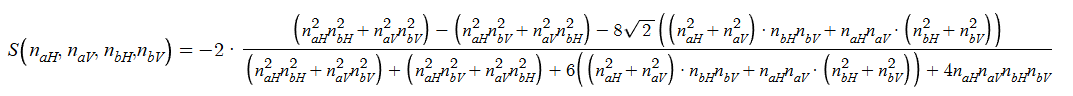

If we define $$\delta_a = \frac{\eta_{aH} - \eta_{aV}}{2}$$ $$\Delta_a = \frac{\eta_{aH} + \eta_{aV}}{2}$$ and do the same for B our equationa for S simplifies to:

In [30]:
delta_a, delta_b, Delta_a, Delta_b = sp.symbols('delta_a delta_b Delta_a Delta_b', real=True)

S_reparam = S_inefficiencies.subs({η_aH: Delta_a + delta_a, η_aV: Delta_a - delta_a, η_bH: Delta_b + delta_b, η_bV: Delta_b - delta_b}).simplify() 
S_reparam


2*(-sqrt(2)*Delta_b + 2*delta_b)/(2*Delta_b - sqrt(2)*delta_b)

If you do an expansion to small order corrections you get
$$
S = S_0 - \frac{\delta_a\delta_b}{\Delta_a\Delta_b}, \quad S_0 = 2\sqrt{2}
$$
from this we see that a difference in efficiency between channels in the same arm doesnt affect S to first order (actually to any order)

### I had a thought!
It doesnt mean much to measure this in terms of effiency differences between the channels on the same side, since i can not really measure this. But i can measure the cross efficiencies, beacuse I can check the coincidence count rates between pairs of channels on opposite sides of the experiment

In [31]:
m_HH, m_HV, m_VH, m_VV, lamb = sp.symbols('m_HH m_HV m_VH m_VV lambda', positive=True, real=True)

S_cross_param = S_inefficiencies.subs({η_aH: lamb, η_aV: lamb * (m_VH / m_HH), η_bH: m_HH / lamb, η_bV: m_VV / (lamb * m_VH / m_HH)}).simplify()

S_cross_param

2*(m_VH*(2 - sqrt(2)) - m_VV*(sqrt(2) + 2))/(m_VH*(2 - sqrt(2)) + m_VV*(sqrt(2) + 2))

### looking for the max S value
I saw from my desmos graphing that i get a clear S above $2 \sqrt{2}$ when the opposite polarisation filters on bob and alice's side are below 1, and it looks like there is a clear maximum possible value slightly above 3, and it looks symmetrical so the max must also be reached when the efficiencies of those two are the same (more general: when their sum is constant - slighly below 0.5, exact below)

In [32]:
(-1*S_inefficiencies.subs({η_aH:η, η_aV:1, η_bH:1, η_bV:η})).simplify()


2*(eta*(sqrt(2) + 2) - 2 + sqrt(2))/(eta*(sqrt(2) + 2) - sqrt(2) + 2)

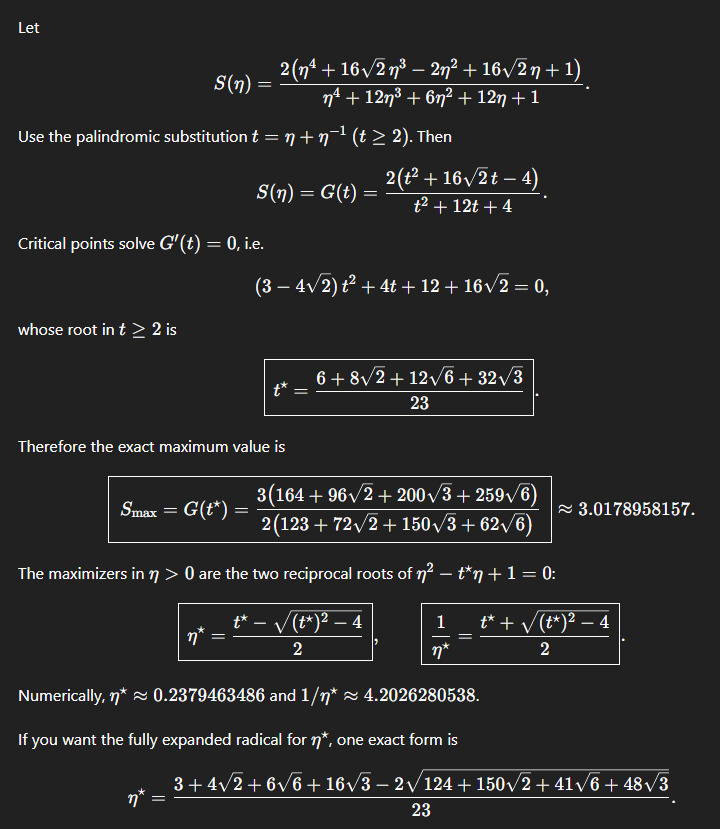
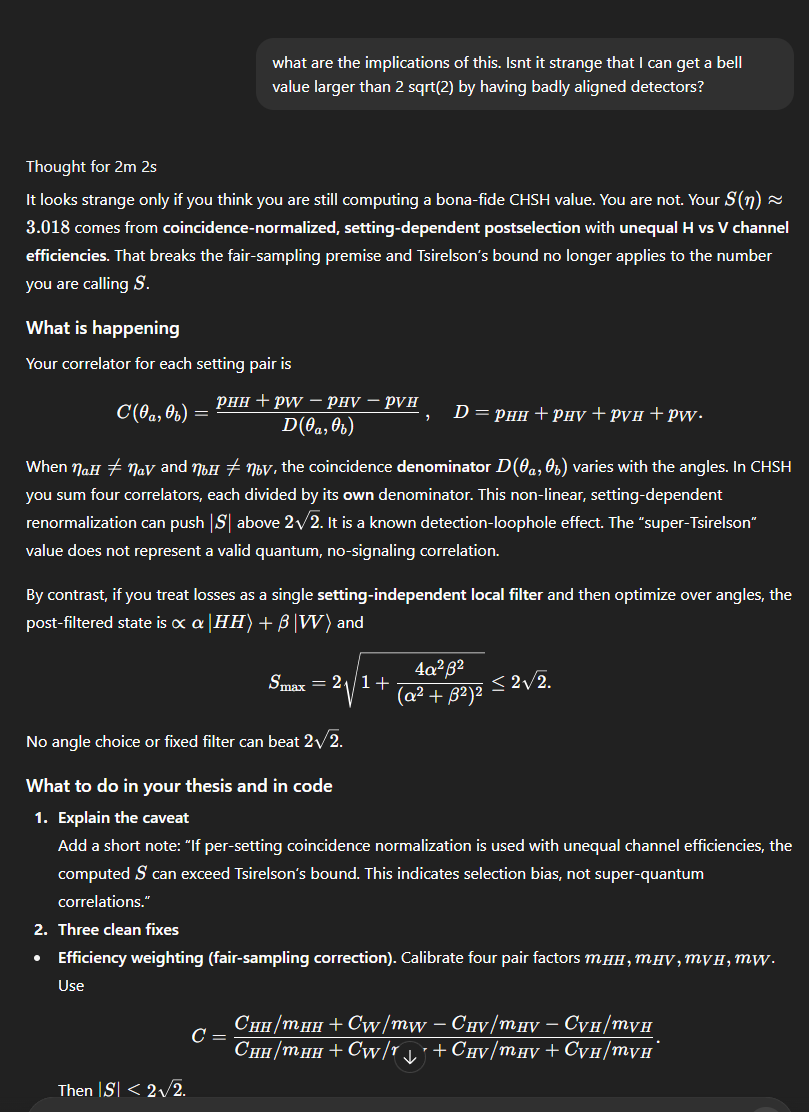

look into Fair sampling assumption, $$\eta > \frac{2}{1+\sqrt{2}} \approx 82.2\%$$ required to close detection loophole. Can i derive this 82.8% from my setup somehow? (my setup in theory)

# improved noisy initial state (WERNER STATE)

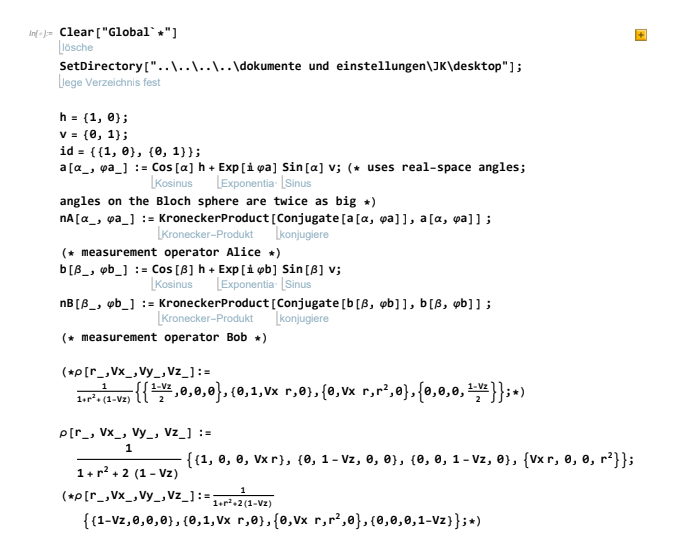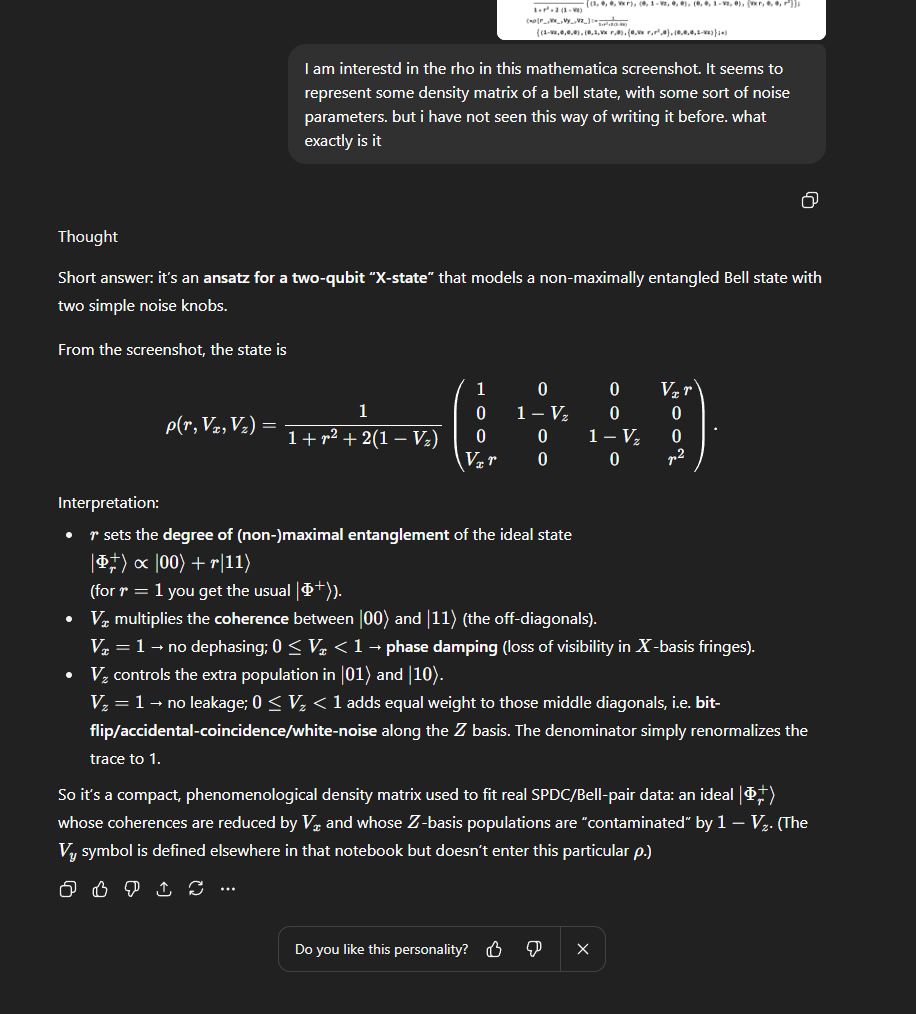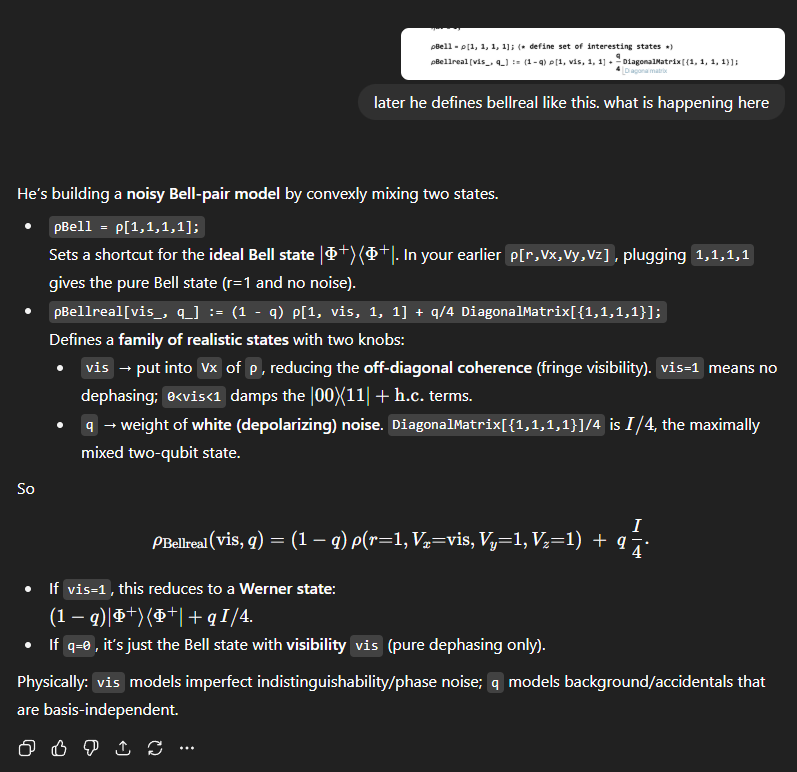